In [1]:
using Pkg
Pkg.activate(".")

  Activating new environment at `~/Documents/Github2/Physics-215-Julia/Session 2 - Measuring code performance/Project.toml`


### KR1 Implemented (customized) at least one math/physics textbook function, or constant (prefer those that involve a sum of a loop) in Julia. Discuss its importance in Physics.

### Elliptic Integral of the First Kind

### $\operatorname{ellipk}(m)
                            = K(m)
                            = \int_0^{ \frac{\pi}{2} } \frac{1}{\sqrt{1 - m \sin^2 \theta}} \, \mathrm{d}\theta
                            \quad \text{for} \quad m \in \left( -\infty, 1 \right]$

Before doing any integration we must define the function that takes care of our integration $\int f(x)dx$. The function below solves the N-point Gaussian approximation of our integral.

In [2]:
using SpecialFunctions
using ProgressMeter

In [3]:
function gaussian_approximation(N,A,B)
    global a = collect(LinRange(3,4*N-1,N))/(4*N+2)
    global x = cos.(pi*a.+1 ./ (8*N*N*tan.(a)))
    
    epsilon = 1e-15
    global delta = 1.0
    while delta > epsilon
        p0 = ones(N)
        p1 = copy(x)
        for k in range(1,N-1, step = 1)
            p0, p1 = p1, ((2*k+1).* x .* p1 .-k .*p0)./ (k+1)
        end
        global dp = (N+1) * (p0 .-x .* p1) ./ (1 .-x.*x)
        dx = p1 ./ dp
        x = x - dx
        global delta = maximum(abs.(dx))
    end
    w = 2*(N+1)*(N+1)./(N*N.*(1 .-x.*x).*dp.*dp)
    return 0.5*(B-A) .* x .+ 0.5 .* (B+A), 0.5.* (B-A) .* w
end 

gaussian_approximation (generic function with 1 method)

In [4]:
function my_func(m,theta)
    return 1 / sqrt(1 - (m * sin(theta)^2))
end

my_func (generic function with 1 method)

In [5]:
function elliptic_integral_first_kind(N,m)
    A = 0
    B = pi/2

    x,w = gaussian_approximation(N,A,B)

    global integral = 0.
    for i in range(1,N, step = 1)
        integral += my_func(m, x[i]) * w[i]
    end
    return integral
end

elliptic_integral_first_kind (generic function with 1 method)

In [6]:
N = 5000
m = 0.5
elliptic_integral_first_kind(N,m)

1.8540746773013743

**Why is the elliptic integral of the first kind important?**

The existence of the elliptic integrals made the calculations for astonomy, physics, algebraic geometry, and topology. For example, elliptic integrals were used to describe Keplerian planetary motions. It is also important in rotational dynamics, electromagnetism, etc. When we want to find the position of a pendulum oscillating, we mostly assume small angle to make our computations simple. But for large angles/displacements, the knowledge of elliptic integrals is important to solve for the position. Its also used in finding particle's positions in an electromagnetic field.

### KR2 Compare the performance (accuracy) of the implemented function in comparison with the existing special functions within Julia (or a reliable module)

There is already a pre-existing function in the `SpecialFunctions` module (`ellipk`) that prints the elliptic integral of the first kind. 

In [7]:
ellipk(m)

1.854074677301372

To check the accuracy of our implemented function compared to the built-in function, we can test different values of m between $(-\infty, 1]$ and for different value of N in our implemented function. The value of N represents the number of slices between our bounds of integration. Higher value of N means more refined integration.

In [8]:
function compute_accuracy()
    m_vals = range(-1,1, length = 15)
    N_vals = floor.(range(10,5000, length = 20))

    difference = zeros(length(N_vals), length(m_vals))
    percent_error = zeros(length(N_vals), length(m_vals))
    
    progress = Progress(length(m_vals)*length(m_vals))
    for i in range(1,length(m_vals), step = 1)
        for j in range(1,length(N_vals), step = 1)
            difference[j,i] = elliptic_integral_first_kind(convert(Int64, N_vals[j]), m_vals[i]) - ellipk(m_vals[i])
            percent_error[j,i] = 100 * ((elliptic_integral_first_kind(convert(Int64, N_vals[j]), m_vals[i]) - ellipk(m_vals[i]))/ellipk(m_vals[i]))
            next!(progress)
        end
    end
    println("function ending")
    return difference, percent_error
end 

compute_accuracy (generic function with 1 method)

In [31]:
difference, percent_error = compute_accuracy();

Progress: 100%|█████████████████████████████████████████| Time: 0:04:18


function ending


In [32]:
using Plots

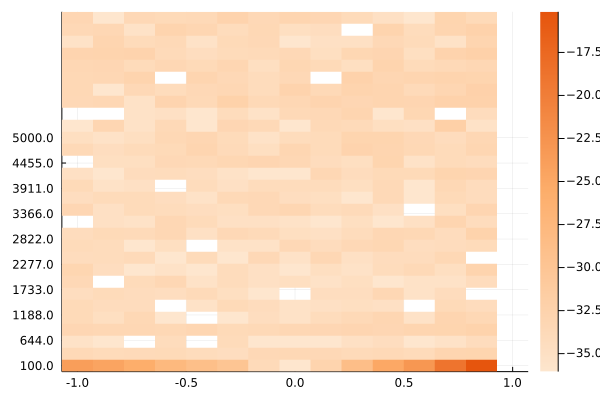

In [33]:
heatmap(log.(abs.(difference)), 
    xticks = (range(1,15, length = 5), range(-1,1, length = 5)), 
    yticks = (range(1,20, length = 10),floor.(range(100,5000, length = 10))),
    padding = (0.0, 0.0),
    c = cgrad(:Oranges_3))

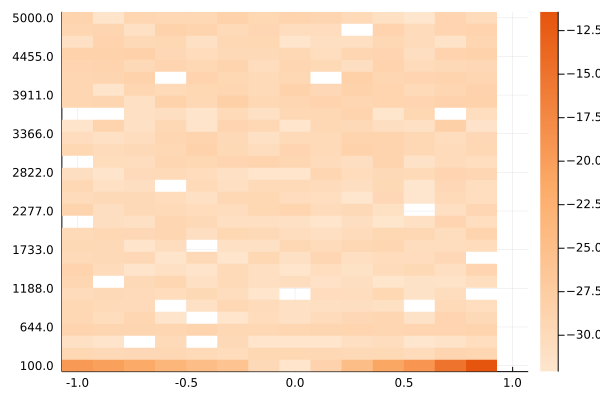

In [34]:
heatmap(log.(abs.(percent_error)), 
    xticks = (range(1,15, length = 5), range(-1,1, length = 5)), 
    yticks = (range(1,30, length = 10),floor.(range(100,5000, length = 10))), 
    padding = (0.0, 0.0),
    c = cgrad(:Oranges_3))

Areas with no data points (white cells) means that the calculated elliptic integral of first kind using the built-in function and my own function is the same. We also notice that at m = 1.0, we all have white cells, no matter the N value is. That is because the built-in function returns an infinity at m = 1, whereas my function returns a value. This is the specific value of m where the built-in function and my own function differs greatly.

Otherwise, looking at the other cells, the darker the shade of the cell means that the farther away my computed value is to the built-in function's computed value. We can see that for small values of N (N represents the number of slices we did in our bounds of integration -- measures how 'fine' our Gaussian approximation is), we have an observable discrepacy in the built-in function and my function. But other than that, the values measured by the two functions are more or less the same.

### KR3 Successful loading of the `BenchmarkTools` module. May need to add it first via the `Pkg` or REPL package mode.

I already added the BenchmarkTools in REPL so i just need to load it here

In [13]:
using BenchmarkTools

### KR4 Itemized differences between `@time`, `@btime`, `@benchmark` and other `@time`-like macros. Nice if the situations when they are best applied are mentioned.

In [14]:
?@time

```
@time
```

A macro to execute an expression, printing the time it took to execute, the number of allocations, and the total number of bytes its execution caused to be allocated, before returning the value of the expression. Any time spent garbage collecting (gc) or compiling is shown as a percentage.

In some cases the system will look inside the `@time` expression and compile some of the called code before execution of the top-level expression begins. When that happens, some compilation time will not be counted. To include this time you can run `@time @eval ...`.

See also [`@timev`](@ref), [`@timed`](@ref), [`@elapsed`](@ref), and [`@allocated`](@ref).

!!! note
    For more serious benchmarking, consider the `@btime` macro from the BenchmarkTools.jl package which among other things evaluates the function multiple times in order to reduce noise.


```julia-repl
julia> x = rand(10,10);

julia> @time x * x;
  0.606588 seconds (2.19 M allocations: 116.555 MiB, 3.75% gc time, 99.94% compilation time)

julia> @time x * x;
  0.000009 seconds (1 allocation: 896 bytes)

julia> @time begin
           sleep(0.3)
           1+1
       end
  0.301395 seconds (8 allocations: 336 bytes)
2
```


In [15]:
?@btime

```
@btime expression [other parameters...]
```

Similar to the `@time` macro included with Julia, this executes an expression, printing the time it took to execute and the memory allocated before returning the value of the expression.

Unlike `@time`, it uses the `@benchmark` macro, and accepts all of the same additional parameters as `@benchmark`.  The printed time is the *minimum* elapsed time measured during the benchmark.


In [16]:
?@benchmark

```
@benchmark <expr to benchmark> [setup=<setup expr>]
```

Run benchmark on a given expression.

# Example

The simplest usage of this macro is to put it in front of what you want to benchmark.

```julia-repl
julia> @benchmark sin(1)
BenchmarkTools.Trial:
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     13.610 ns (0.00% GC)
  median time:      13.622 ns (0.00% GC)
  mean time:        13.638 ns (0.00% GC)
  maximum time:     21.084 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     998
```

You can interpolate values into `@benchmark` expressions:

```julia
# rand(1000) is executed for each evaluation
julia> @benchmark sum(rand(1000))
BenchmarkTools.Trial:
  memory estimate:  7.94 KiB
  allocs estimate:  1
  --------------
  minimum time:     1.566 μs (0.00% GC)
  median time:      2.135 μs (0.00% GC)
  mean time:        3.071 μs (25.06% GC)
  maximum time:     296.818 μs (95.91% GC)
  --------------
  samples:          10000
  evals/sample:     10

# rand(1000) is evaluated at definition time, and the resulting
# value is interpolated into the benchmark expression
julia> @benchmark sum($(rand(1000)))
BenchmarkTools.Trial:
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     101.627 ns (0.00% GC)
  median time:      101.909 ns (0.00% GC)
  mean time:        103.834 ns (0.00% GC)
  maximum time:     276.033 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     935
```


In [17]:
?@timev

```
@timev
```

This is a verbose version of the `@time` macro. It first prints the same information as `@time`, then any non-zero memory allocation counters, and then returns the value of the expression.

See also [`@time`](@ref), [`@timed`](@ref), [`@elapsed`](@ref), and [`@allocated`](@ref).

```julia-repl
julia> x = rand(10,10);

julia> @timev x * x;
  0.546770 seconds (2.20 M allocations: 116.632 MiB, 4.23% gc time, 99.94% compilation time)
elapsed time (ns): 546769547
gc time (ns):      23115606
bytes allocated:   122297811
pool allocs:       2197930
non-pool GC allocs:1327
malloc() calls:    36
realloc() calls:   5
GC pauses:         3

julia> @timev x * x;
  0.000010 seconds (1 allocation: 896 bytes)
elapsed time (ns): 9848
bytes allocated:   896
pool allocs:       1
```


**Discussion:**

**`@time`** 
 - The time macro is a built-in function in Julia which makes it a convenient macro that can be used anytime if you care about the code performance.
 - This macro measures the elapsed time (including compilation time) of the provided expresion that you wrapped it with. This also prints the memory allocated while running the code.
 - Useful for benchmarking scripts that run slowly.
 
**`@btime`**
 - This macro is from the `BenchmarkTools` and is similar to the `@time` macro in the sense that it also computes for the time it takes for the script/function to run as well as the memory allocation.
 - One thing that makes it different from the `@time` macro is that it doesn't measure the compilation time of the function, only the runtime.
 - This macro also does multiple measurements of time elapsed which reduces the noise, making it useful when you are trying to optimize a function that you need to run multiple times.
 - This macro prints the minimum time it takes for the function to run.
 
**`@benchmark`**
 - This macro is similar with `@btime` -- both evaluates/runs the function multiple times and applies statistical analysis
 - This macro in particular prints different values of time (minimum runtime, maximum, median, mean) as well as the memory allocation estimate.
 
 **Other time macros**
  - `@timev` (verbose time) - this marco measures some additional memory statistics, compared to `@time`, as well as the elapsed time measurements in the nanosecond precision.
  - `@elapsed` - just measures the time it takes for the function to run. which means this is useful when we want to use the time value for further processing

Now let us apply the different macros mentioned above to our own function

In [18]:
@time elliptic_integral_first_kind(N,m)

  1.195842 seconds (334.00 k allocations: 775.248 MiB, 14.97% gc time)


1.8540746773013743

In [19]:
@btime elliptic_integral_first_kind(N,m)

  942.363 ms (333999 allocations: 775.25 MiB)


1.8540746773013743

In [20]:
@benchmark elliptic_integral_first_kind(N,m)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  848.891 ms …   1.084 s  ┊ GC (min … max): 16.50% … 14.64%
 Time  (median):     915.311 ms              ┊ GC (median):    16.16%
 Time  (mean ± σ):   941.087 ms ± 98.557 ms  ┊ GC (mean ± σ):  15.83% ±  1.23%

  ██    █                    █                 █             █  
  ██▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  849 ms          Histogram: frequency by time          1.08 s <

 Memory estimate: 775.25 MiB, allocs estimate: 333999.

In [21]:
@time ellipk(m)

  0.000006 seconds (1 allocation: 16 bytes)


1.854074677301372

In [22]:
@btime ellipk(m)

  52.206 ns (1 allocation: 16 bytes)


1.854074677301372

In [23]:
@benchmark ellipk(m)

BenchmarkTools.Trial: 10000 samples with 986 evaluations.
 Range (min … max):  56.212 ns …  15.527 μs  ┊ GC (min … max): 0.00% … 99.58%
 Time  (median):     57.798 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   61.614 ns ± 155.130 ns  ┊ GC (mean ± σ):  2.51% ±  1.00%

  ▆█▃ ▁▂▃                                                      ▁
  ███▇████▆▄▇▇████▆▆▆▆▆▅▅▅▅▆▅▅▆▅▆▆▅▅▅▅▄▅▅▅▆▅▆▅▅▄▅▃▄▄▄▄▃▅▂▃▄▄▃▃ █
  56.2 ns       Histogram: log(frequency) by time       112 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

Now, we can actually look at the value of `@benchmark elliptic_integral_first_kind(N,m)` and `@benchmark ellipk(m)` since it is the macro out of the three that gives the most details.

For our own implemented function, we can see that the mean time is 941 ms while for the built-in function the mean is just 61.614 ns, which is ~$10^6$ faster than our implemented function. We can also see that the memory allocation is just 16 bytes for the built-in function while we have around 800mb for the implemented function.

The reason for this is that my implemented function computes for the integral/weights that we will use for our gaussian approximation integral and also our function has a while loop that repeatedly computes the integral until we get our desired accuracy. 

On the other hand, the built-in function is fast because of computing for the elliptic integral every time, it just uses a lookup table and I guess it interpolates missing values in between. The snippet of code below shows a part of the source code of `ellipk()`

```
function ellipk(m::Float64)
    flag_is_m_neg = false
    if m < 0.0
        x               = m / (m-1)         #dealing with negative args
        flag_is_m_neg   = true
    elseif m >= 0.0
        x               = m
        flag_is_m_neg   = false
    end

    if x == 0.0
        return Float64(halfπ)

    elseif x == 1.0
        return Inf

    elseif x > 1.0
        throw(DomainError(m, "`m` must lie between -Inf and 1 ---- Domain: (-Inf,1.0]"))

    elseif 0.0 <= x < 0.1   #Table 2 from paper
        t = x-0.05
        t = @horner(t,
            1.591003453790792180 , 0.416000743991786912 , 0.245791514264103415 ,
            0.179481482914906162 , 0.144556057087555150 , 0.123200993312427711 ,
            0.108938811574293531 , 0.098853409871592910 , 0.091439629201749751 ,
            0.085842591595413900 , 0.081541118718303215)

    elseif 0.1 <= x < 0.2  #Table 3
        t = x-0.15
        t = @horner(t ,
            1.635256732264579992 , 0.471190626148732291 , 0.309728410831499587 ,
            0.252208311773135699 , 0.226725623219684650 , 0.215774446729585976 ,
            0.213108771877348910 , 0.216029124605188282 , 0.223255831633057896 ,
            0.234180501294209925 , 0.248557682972264071 , 0.266363809892617521)
```

Since the built-in function doesnt compute the every time, it makes it much much faster than our own function. And in terms of accuracy, the built-in function is dependent on the accuracy of the paper that they got the values from (DOI:10.13140/2.1.1946.6245).

### KR5 Identified demonstrated useful features within the `Profile` module of Julia. Features must be explained why useful for your case.

In [24]:
using Profile

In [25]:
?@profile

```
@profile
```

`@profile <expression>` runs your expression while taking periodic backtraces. These are appended to an internal buffer of backtraces.


In [45]:
Profile.clear()

In [46]:
@profile elliptic_integral_first_kind(N,m)

1.8540746773013743

The `@profile` macro will collect some 'profile' information for us. The output (as seen from above) is just the result of our function, while the collected information was stored in memory. To view the stored profile information. we can use the `print` option.

In [47]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
   ╎774  @Base/task.jl:411; (::IJulia.var"#15#18")()
   ╎ 774  ...lia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
   ╎  774  @Base/essentials.jl:706; invokelatest
   ╎   774  @Base/essentials.jl:708; #invokelatest#2
   ╎    774  .../execute_request.jl:67; execute_request(socket::ZMQ.So...
   ╎     774  ...SoftGlobalScope.jl:65; softscope_include_string(m::M...
   ╎    ╎ 774  @Base/loading.jl:1116; include_string(mapexpr::typ...
   ╎    ╎  774  @Base/boot.jl:360; eval
   ╎    ╎   774  In[5]:5; elliptic_integral_first_kind...
   ╎    ╎    1    In[3]:8; gaussian_approximation(N::I...
   ╎    ╎     1    @Base/array.jl:498; ones
   ╎    ╎    ╎ 1    @Base/array.jl:500; ones
   ╎    ╎    ╎  1    @Base/array.jl:504; ones
   ╎    ╎    ╎   1    @Base/array.jl:335; fill!
  1╎    ╎    ╎    1    @Base/array.jl:839; setindex!
 77╎    ╎    772  In[3]:11; gaussian_approximation(N::I...
  1╎    ╎     62   @Base/broadcast.jl:1315; broadcast

In [48]:
Profile.print(format=:flat, sortedby=:count)

 Count  Overhead File                    Line Function
 =====  ======== ====                    ==== ========
     1         1 @Base/array.jl             ? Float64
     1         0 @Base/number.jl            7 convert
     1         0 @Base/promotion.jl       269 _promote
     1         0 @Base/promotion.jl       292 promote
     1         1 @Base/broadcast.jl       170 Broadcasted
     1         0 @Base/broadcast.jl       179 Broadcasted
     1         0 @Base/broadcast.jl       179 (Base.Broadcast.Broadcasted{Bas...
     1         0 @Base/array.jl           335 fill!
     1         0 @Base/array.jl           504 ones
     1         0 @Base/array.jl           500 ones
     1         0 @Base/array.jl           498 ones
     1         0 In[3]                      8 gaussian_approximation(N::Int64...
     1         1 @Base/simdloop.jl          ? materialize(bc::Base.Broadcast....
     1         1 @Base/abstractarray.jl  1384 mightalias
     1         0 @Base/abstractarray.jl  1349 unalia

Instead of printing the profile information, we can actually use the `ProfileView` package which makes us visualize the information above.

In [49]:
using ProfileView

In [50]:
ProfileView.view()

Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=1, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip-taskbar-hint

./array.jl:839, setindex! [inlined]


![alt text](profile_own_func.png "ProfileView Own Function")

The Profile module is a powerful tool that makes us 'backtrace' our code and see the areas or lines of code that contributes more in the runtime of our function. Higher count number means higher contribution in the runtime. Now, I used the `Profile.print()` and `ProfileView.view()` functions to get a list and graph output that gives me details on how my code performs under the hood.

The `Profile.print()` prints a nested output wherein the lines that are more indented are called after the line before it (less indented run). Now I applied the `format=:flat` and `sorted=:count` to the `Profile.print()` just to make it more readable to me. In this way, I organized the processes from least number of times the line is sampled (count) to the lines with greatest count.

The `ProfileView.view()` works similarly in a way that the bottom blocks (blocks represents functions/processes being called) are called/performed first and the blocks on top of it are performed after. We see that the blocks are getting more 'diverse' as we go to the top part of our graph showing that there are multiple processes being done. The thickness of the blocks are all the same and that depends on the sampling interval of our profiler. The widths on the other hand are different. The width represent the time it takes for the process to run.

I used the two listed above on my built-in function in order to see what areas of my code are taking long to run.

### KR6 A discussion of the performance of the implemented function above.

We can see the the `Profile.print()` and the view as well that the `gaussian_approximation()` function is the one that makes our own function take a long time to run 

`772        77 In[3]                     11 gaussian_approximation(N::Int64...`

This actually makes sense because the `gaussian_approximation` process is the one that computes the integral. Now if we look at the nested lines in the `gaussian_approximation()` process, we see that the lines that call `broadcast.jl` to implement the `broadcast` and `materialize` functions are the ones who take most of the time. These two are the ones responsible for broadcasting arrays types (not really sure po). Not really sure what it means since I don't really get the source code but from what I can infer based on the nested lines from the `Profile.view()` is that it takes long to copy and create arrays. It is fast to perform the matrix operations but a significant of time is also taken up by the setindex! function:

`499╎    ╎    ╎    ╎ 499  @Base/array.jl:839; setindex!`

Documentation of setindex!:

```
"""
    setindex!(collection, value, key...)
Store the given value at the given key or index within a collection. The syntax `a[i,j,...] =
x` is converted by the compiler to `(setindex!(a, x, i, j, ...); x)`.
"""
```

We see that this agrees with our discussion earlier that creating an array takes a long time since the `setindex!` function stores a value in an array.

**Summary**

Summarizing my points from **KR2**, **KR4**, and **KR5**, my implemented function for the elliptic integral of the first kind performs slower (~$10^6$%) that the built-in Julia function for it. This is because the built-in function uses a look-up table, whose values were copied from a published paper, instead of computing the values of the elliptic integral every time. My own function makes use of gaussian approximation which computes for the integral, and is dependent on the number of slices made as well as the level accuracy that we set. Even though my own function performs slower and takes up too much memory compared to the built-in one, in terms of accuracy, there is actually a small difference between the two. If we look at our heatmap again, I had to take the logarithm of the values since they are so small to notice. We see that higher numbers of slices done to our integration makes my function accurate.

Looking at the profiler results, we see that the reason why my function takes a long time to run is because of my use of arrays. And since a lot of lines in my code uses arrays, it takes a long time to store values and copy matrices. 